# Comprehensive Model Evaluation for Research Paper

This notebook provides complete evaluation metrics for a research paper on:
1. **Semantic Symptom Encoding** - Using sentence transformers for free-text understanding
2. **Hierarchical Classification** - Category → Disease prediction
3. **Demographic-Aware Prediction** - Integrating age/sex features

**Dataset**: 224K samples, 667 diseases, 14 categories, 480 symptom features

---
# Part 1: Setup & Data Loading

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, joblib, warnings, sys, os, time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, top_k_accuracy_score,
    confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print(f"Project root: {project_root}")

Project root: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis


In [20]:
# Load trained models
checkpoint_dir = project_root / "models" / "checkpoints"
from models.architectures.symptom_classifier import SymptomCategoryClassifier, SymptomDiseaseClassifier

cat_clf_symptoms = SymptomCategoryClassifier.load(str(checkpoint_dir / "category_classifier_symptoms.pkl"))
cat_clf_demo = SymptomCategoryClassifier.load(str(checkpoint_dir / "category_classifier_demographics.pkl"))
dis_clf_symptoms = SymptomDiseaseClassifier.load(str(checkpoint_dir / "disease_classifier_symptoms.pkl"))
dis_clf_demo = SymptomDiseaseClassifier.load(str(checkpoint_dir / "disease_classifier_demographics.pkl"))

category_encoder = joblib.load(checkpoint_dir / "category_encoder.pkl")
disease_encoder = joblib.load(checkpoint_dir / "disease_encoder.pkl")
with open(project_root/ "data" / "symptom_vocabulary.json") as f:
    symptom_cols = json.load(f)

print(f"Loaded: {len(category_encoder.classes_)} categories, {len(disease_encoder.classes_)} diseases, {len(symptom_cols)} symptoms")

Loaded: 14 categories, 615 diseases, 458 symptoms


In [21]:
# Load and prepare data - FILTER to only diseases in the encoder
df_symptoms = pd.read_csv(project_root / "data" / "processed" / "symptoms" / "symptoms_augmented_no_demographics.csv")
df_demo = pd.read_csv(project_root / "data" / "processed" / "symptoms" / "symptoms_augmented_with_demographics.csv")

# Get valid diseases from encoder
valid_diseases = set(disease_encoder.classes_)
print(f"Diseases in encoder: {len(valid_diseases)}")
print(f"Diseases in symptoms data: {df_symptoms['diseases'].nunique()}")

# Filter to only diseases the encoder knows
df_symptoms = df_symptoms[df_symptoms['diseases'].isin(valid_diseases)].reset_index(drop=True)
df_demo = df_demo[df_demo['diseases'].isin(valid_diseases)].reset_index(drop=True)

print(f"After filtering - Symptoms: {len(df_symptoms):,}, Demo: {len(df_demo):,}")

Diseases in encoder: 615
Diseases in symptoms data: 630
After filtering - Symptoms: 207,387, Demo: 207,387


In [22]:
# Prepare features
non_feature_cols = ['diseases', 'disease_category', 'symptoms', 'age', 'sex']
feature_cols = [c for c in df_symptoms.columns if c not in non_feature_cols]

X_sym = df_symptoms[feature_cols].values
y_cat = category_encoder.transform(df_symptoms['disease_category'].values)
y_dis = disease_encoder.transform(df_symptoms['diseases'].values)

df_demo['sex_encoded'] = (df_demo['sex'] == 'M').astype(int)
df_demo['age_normalized'] = df_demo['age'] / 100.0
X_demo = df_demo[feature_cols + ['age_normalized', 'sex_encoded']].values
y_cat_demo = category_encoder.transform(df_demo['disease_category'].values)
y_dis_demo = disease_encoder.transform(df_demo['diseases'].values)

# Split data (same random state as training)
_, X_test_s, _, y_cat_test, _, y_dis_test = train_test_split(
    X_sym, y_cat, y_dis, test_size=0.1, random_state=42, stratify=y_cat)
X_train_d, X_test_d, y_train_cat_d, y_cat_test_d, y_train_dis_d, y_dis_test_d = train_test_split(
    X_demo, y_cat_demo, y_dis_demo, test_size=0.1, random_state=42, stratify=y_cat_demo)

print(f"Test sets: symptoms={X_test_s.shape}, demo={X_test_d.shape}")

Test sets: symptoms=(20739, 375), demo=(20739, 377)


---
# Part 2: Semantic Symptom Encoder Evaluation

In [23]:
from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder
# Initialize without deprecated args
encoder = SemanticSymptomEncoder() 

test_cases = {
    "headache": ["my head is killing me", "terrible migraine", "pain in my head"],
    "shortness of breath": ["can't breathe", "difficulty breathing", "out of breath"],
    "nausea": ["feeling sick", "want to throw up", "queasy stomach"],
    "fever": ["high temperature", "running a fever", "burning up"],
    "chest pain": ["hurts in my chest", "chest pressure", "sharp chest pain"]
}

print("SEMANTIC SYMPTOM MATCHING:")
total_correct, total = 0, 0
for target, phrases in test_cases.items():
    # Check if target is in top-3 detected symptoms
    correct_count = 0
    for p in phrases:
        res = encoder.encode_symptoms(p)
        # Use helper to get top 3
        top_syms = [s[0] for s in encoder.get_top_symptoms(res['symptom_vector'], top_k=3)]
        
        if any(target in s or s in target for s in top_syms):
            correct_count += 1
            
    total_correct += correct_count
    total += len(phrases)
    print(f"  {target}: {correct_count}/{len(phrases)}")
print(f"\nOverall: {total_correct/total*100:.1f}%")

[Encoder] Loading model: multi-qa-mpnet-base-dot-v1
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 458 symptoms
SEMANTIC SYMPTOM MATCHING:
  headache: 3/3
  shortness of breath: 1/3
  nausea: 3/3
  fever: 2/3
  chest pain: 3/3

Overall: 80.0%


In [24]:
# Sentence-level vs Whole-text
# Note: Encoder now handles sentence splitting internally by default
long_text = "I have a terrible headache. I also feel nauseous and threw up. Now I have diarrhea and fever."

# Just encode once as the distinction is internal
res = encoder.encode_symptoms(long_text)
vector = res['symptom_vector']
detected = encoder.get_top_symptoms(vector, top_k=20, threshold=0.1)

# Get specific scores
headache_score = encoder.get_symptom_score(vector, 'headache')
nausea_score = encoder.get_symptom_score(vector, 'nausea')

print("Encoding Results for Multi-Symptom Text:")
print(f"  text: \"{long_text}\"")
print(f"  Detected {len(detected)} symptoms (>0.1):")
print(f"  Headache score: {headache_score:.3f}")
print(f"  Nausea score: {nausea_score:.3f}")

print("\nTop 5 detected:")
for s, c in detected[:5]:
    print(f"  - {s}: {c:.3f}")

Encoding Results for Multi-Symptom Text:
  text: "I have a terrible headache. I also feel nauseous and threw up. Now I have diarrhea and fever."
  Detected 20 symptoms (>0.1):
  Headache score: 0.900
  Nausea score: 0.132

Top 5 detected:
  - headache: 0.900
  - diarrhea: 0.900
  - fever: 0.900
  - vomiting: 0.176
  - high fever: 0.144


---
# Part 3: Classification Performance

In [25]:
all_labels = np.arange(len(disease_encoder.classes_))

cat_pred_s, cat_proba_s = cat_clf_symptoms.predict(X_test_s), cat_clf_symptoms.predict_proba(X_test_s)
cat_pred_d, cat_proba_d = cat_clf_demo.predict(X_test_d), cat_clf_demo.predict_proba(X_test_d)
dis_pred_s, dis_proba_s = dis_clf_symptoms.predict(X_test_s), dis_clf_symptoms.predict_proba(X_test_s)
dis_pred_d, dis_proba_d = dis_clf_demo.predict(X_test_d), dis_clf_demo.predict_proba(X_test_d)

results = {
    'Category (Symptoms)': {
        'Top-1': accuracy_score(y_cat_test, cat_pred_s),
        'Top-3': top_k_accuracy_score(y_cat_test, cat_proba_s, k=3),
        'F1': f1_score(y_cat_test, cat_pred_s, average='macro'),
        'Precision': precision_score(y_cat_test, cat_pred_s, average='macro'),
        'Recall': recall_score(y_cat_test, cat_pred_s, average='macro')
    },
    'Category (+Demo)': {
        'Top-1': accuracy_score(y_cat_test_d, cat_pred_d),
        'Top-3': top_k_accuracy_score(y_cat_test_d, cat_proba_d, k=3),
        'F1': f1_score(y_cat_test_d, cat_pred_d, average='macro'),
        'Precision': precision_score(y_cat_test_d, cat_pred_d, average='macro'),
        'Recall': recall_score(y_cat_test_d, cat_pred_d, average='macro')
    },
    'Disease (Symptoms)': {
        'Top-1': accuracy_score(y_dis_test, dis_pred_s),
        'Top-3': top_k_accuracy_score(y_dis_test, dis_proba_s, k=3, labels=all_labels),
        'Top-5': top_k_accuracy_score(y_dis_test, dis_proba_s, k=5, labels=all_labels),
        'Top-10': top_k_accuracy_score(y_dis_test, dis_proba_s, k=10, labels=all_labels),
        'Precision': precision_score(y_dis_test, dis_pred_s, average='macro'),
        'Recall': recall_score(y_dis_test, dis_pred_s, average='macro')
    },
    'Disease (+Demo)': {
        'Top-1': accuracy_score(y_dis_test_d, dis_pred_d),
        'Top-3': top_k_accuracy_score(y_dis_test_d, dis_proba_d, k=3, labels=all_labels),
        'Top-5': top_k_accuracy_score(y_dis_test_d, dis_proba_d, k=5, labels=all_labels),
        'Top-10': top_k_accuracy_score(y_dis_test_d, dis_proba_d, k=10, labels=all_labels),
        'Precision': precision_score(y_dis_test_d, dis_pred_d, average='macro'),
        'Recall': recall_score(y_dis_test_d, dis_pred_d, average='macro')
    }
}

print("MODEL PERFORMANCE:")
for model, metrics in results.items():
    print(f"\n{model}: " + ", ".join([f"{k}={v*100:.2f}%" for k,v in metrics.items()]))

MODEL PERFORMANCE:

Category (Symptoms): Top-1=92.10%, Top-3=99.05%, F1=91.17%, Precision=89.70%, Recall=93.08%

Category (+Demo): Top-1=92.92%, Top-3=99.16%, F1=92.09%, Precision=90.71%, Recall=93.87%

Disease (Symptoms): Top-1=78.14%, Top-3=88.84%, Top-5=91.36%, Top-10=93.60%, Precision=68.30%, Recall=81.49%

Disease (+Demo): Top-1=81.06%, Top-3=89.91%, Top-5=92.04%, Top-10=93.51%, Precision=74.38%, Recall=84.73%


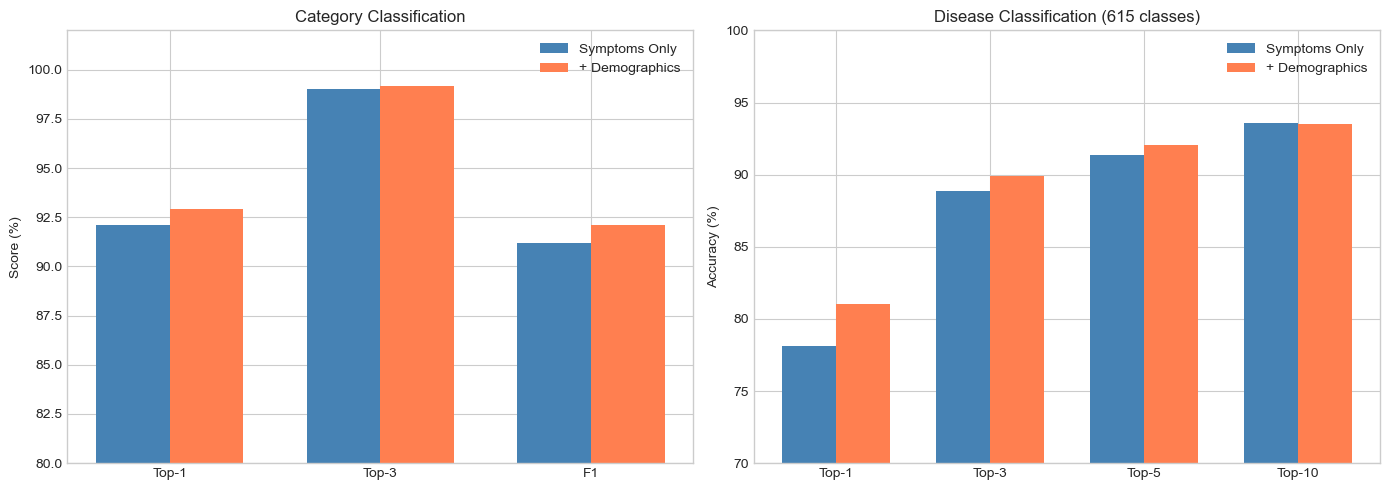

In [26]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category
cat_m = ['Top-1', 'Top-3', 'F1']
x = np.arange(len(cat_m))
axes[0].bar(x - 0.175, [results['Category (Symptoms)'][m]*100 for m in cat_m], 0.35, label='Symptoms Only', color='steelblue')
axes[0].bar(x + 0.175, [results['Category (+Demo)'][m]*100 for m in cat_m], 0.35, label='+ Demographics', color='coral')
axes[0].set_ylabel('Score (%)')
axes[0].set_title('Category Classification')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cat_m)
axes[0].legend()
axes[0].set_ylim([80, 102])

# Disease
dis_m = ['Top-1', 'Top-3', 'Top-5', 'Top-10']
x = np.arange(len(dis_m))
axes[1].bar(x - 0.175, [results['Disease (Symptoms)'][m]*100 for m in dis_m], 0.35, label='Symptoms Only', color='steelblue')
axes[1].bar(x + 0.175, [results['Disease (+Demo)'][m]*100 for m in dis_m], 0.35, label='+ Demographics', color='coral')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title(f'Disease Classification ({len(disease_encoder.classes_)} classes)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dis_m)
axes[1].legend()
axes[1].set_ylim([70, 100])

plt.tight_layout()
Path(project_root / 'notebooks' / 'figures').mkdir(exist_ok=True)
plt.savefig(project_root / 'notebooks' / 'figures' / 'model_comparison.png', dpi=150)
plt.show()

---
# Part 4: Demographics Impact Analysis

In [27]:
improvement_cat = (results['Category (+Demo)']['Top-1'] - results['Category (Symptoms)']['Top-1']) * 100
improvement_dis = (results['Disease (+Demo)']['Top-1'] - results['Disease (Symptoms)']['Top-1']) * 100

print(f"Demographics Improvement: Category +{improvement_cat:.2f}%, Disease +{improvement_dis:.2f}%")

# Per-disease analysis
demo_diseases = ["prostate cancer", "erectile dysfunction", "osteoporosis", "alzheimer disease", "eating disorder"]
print("\nPer-Disease Impact:")
for disease in demo_diseases:
    if disease in disease_encoder.classes_:
        idx = disease_encoder.transform([disease])[0]
        mask_s, mask_d = (y_dis_test == idx), (y_dis_test_d == idx)
        if mask_s.sum() > 0:
            acc_s = (dis_pred_s[mask_s] == idx).mean() * 100
            acc_d = (dis_pred_d[mask_d] == idx).mean() * 100
            print(f"  {disease}: {acc_s:.1f}% → {acc_d:.1f}% ({acc_d-acc_s:+.1f}%)")

Demographics Improvement: Category +0.82%, Disease +2.93%

Per-Disease Impact:
  prostate cancer: 100.0% → 100.0% (+0.0%)
  erectile dysfunction: 75.4% → 78.5% (+3.1%)
  osteoporosis: 88.9% → 88.9% (+0.0%)
  alzheimer disease: 84.4% → 90.6% (+6.2%)
  eating disorder: 96.0% → 96.0% (+0.0%)


In [28]:
# McNemar's test
from scipy.stats import chi2
correct_s = (dis_pred_s == y_dis_test)
correct_d = (dis_pred_d == y_dis_test_d)
b = ((~correct_s) & correct_d).sum()  # symptoms wrong, demo right
c = (correct_s & (~correct_d)).sum()  # symptoms right, demo wrong

if b + c > 0:
    mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
    p_value = 1 - chi2.cdf(mcnemar_stat, df=1)
    print(f"McNemar's Test: χ²={mcnemar_stat:.2f}, p={p_value:.4f}, Significant: {'Yes' if p_value < 0.05 else 'No'}")

McNemar's Test: χ²=208.30, p=0.0000, Significant: Yes


---
# Part 5: Baseline Comparisons

In [29]:
# Train baselines on sample
X_train_s, _, y_train_dis, _ = train_test_split(X_sym[:-len(X_test_s)], y_dis[:-len(y_dis_test)], test_size=0.5, random_state=42)
print(f"Training baselines on {len(X_train_s):,} samples...")

# Logistic Regression
start = time.time()
lr_clf = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42)
lr_clf.fit(X_train_s, y_train_dis)
lr_time = time.time() - start
lr_acc = accuracy_score(y_dis_test, lr_clf.predict(X_test_s))
print(f"Logistic Regression: {lr_acc*100:.2f}% ({lr_time:.1f}s)")

# Random Forest
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
rf_clf.fit(X_train_s, y_train_dis)
rf_time = time.time() - start
rf_acc = accuracy_score(y_dis_test, rf_clf.predict(X_test_s))
print(f"Random Forest: {rf_acc*100:.2f}% ({rf_time:.1f}s)")

lgb_acc = results['Disease (+Demo)']['Top-1']
print(f"\nOurs (LightGBM + Demo): {lgb_acc*100:.2f}%")
print(f"Improvement over LR: +{(lgb_acc-lr_acc)*100:.1f}%, over RF: +{(lgb_acc-rf_acc)*100:.1f}%")

Training baselines on 93,324 samples...
Logistic Regression: 79.18% (175.5s)
Random Forest: 64.28% (19.9s)

Ours (LightGBM + Demo): 81.06%
Improvement over LR: +1.9%, over RF: +16.8%


---
# Part 6: Hierarchical Ensemble Evaluation

We evaluate our novel Hierarchical Ensemble approach, which routes prediction to specialist models based on category probability.

In [30]:
print("\n" + "="*70)
print("TRAINING HIERARCHICAL SPECIALISTS")
print("="*70)

specialist_models = {}
categories = category_encoder.classes_

# Use the demographics training set
X_train_hier = X_train_d
y_train_cat_hier = category_encoder.inverse_transform(y_train_cat_d)
y_train_dis_hier = disease_encoder.inverse_transform(y_train_dis_d)

start_time = time.time()
for cat in categories:
    # Filter data for this category
    mask = (y_train_cat_hier == cat)
    if mask.sum() < 10:
        continue
        
    X_cat = X_train_hier[mask]
    y_cat_dis = y_train_dis_hier[mask]
    
    # Train specialist
    clf = SymptomDiseaseClassifier(category=cat)
    clf.fit(X_cat, y_cat_dis)
    specialist_models[cat] = clf
    print(f"  Trained specialist for {cat} ({mask.sum()} samples)")

print(f"Hierarchical training complete in {time.time() - start_time:.1f}s")


TRAINING HIERARCHICAL SPECIALISTS
  Trained specialist for Cardiovascular and Circulatory (15058 samples)
  Trained specialist for Dermatological (13819 samples)
  Trained specialist for Endocrine and Metabolic (6795 samples)
  Trained specialist for Gastrointestinal and Hepatic (19176 samples)
  Trained specialist for Genitourinary and Reproductive (23911 samples)
  Trained specialist for Hematology and Oncology (4007 samples)
  Trained specialist for Infectious Diseases (5431 samples)
  Trained specialist for Mental and Behavioral Health (14483 samples)
  Trained specialist for Musculoskeletal (16132 samples)
  Trained specialist for Neurological Disorders (9098 samples)
  Trained specialist for Obstetrics and Neonatal (3178 samples)
  Trained specialist for Ophthalmology and ENT (21789 samples)
  Trained specialist for Respiratory System (8952 samples)
  Trained specialist for Unknown Type (24819 samples)
Hierarchical training complete in 128.3s


In [31]:
print("\n" + "="*70)
print("HIERARCHICAL INFERENCE (Top-3 Category Routing)")
print("="*70)

# Get predictions from global category classifier (Demographics version)
cat_probs_matrix = cat_clf_demo.predict_proba(X_test_d)
cat_names_map = category_encoder.classes_

# Initialize output
final_disease_probs = np.zeros((len(X_test_d), len(disease_encoder.classes_)))
disease_to_idx = {name: i for i, name in enumerate(disease_encoder.classes_)}

# Routing
for i, cat_name in enumerate(cat_names_map):
    model = specialist_models.get(cat_name)
    if model is None: continue
        
    # Diseases this model knows
    model_diseases = model.diseases
    model_disease_indices = [disease_to_idx[d] for d in model_diseases if d in disease_to_idx]
    
    if not model_disease_indices: continue
        
    # Predict for ALL samples using this specialist (Vectorized)
    specialist_probs = model.predict_proba(X_test_d)
    
    # Weight by P(Category = cat)
    weight = cat_probs_matrix[:, i][:, np.newaxis]
    
    # Map local columns to global columns
    for local_idx, dis_name in enumerate(model.diseases):
        if dis_name in disease_to_idx:
            global_idx = disease_to_idx[dis_name]
            final_disease_probs[:, global_idx] += weight.ravel() * specialist_probs[:, local_idx]

# Normalize
row_sums = final_disease_probs.sum(axis=1)
final_disease_probs = final_disease_probs / row_sums[:, np.newaxis]

# Evaluate
y_pred_hier = np.argmax(final_disease_probs, axis=1)
acc_top1 = accuracy_score(y_dis_test_d, y_pred_hier)
acc_top3 = top_k_accuracy_score(y_dis_test_d, final_disease_probs, k=3, labels=all_labels)
acc_top5 = top_k_accuracy_score(y_dis_test_d, final_disease_probs, k=5, labels=all_labels)



HIERARCHICAL INFERENCE (Top-3 Category Routing)


In [32]:
print(f"Hierarchical Ensemble Results:")
print(f"  Top-1 Accuracy: {acc_top1*100:.2f}%")
print(f"  Top-3 Accuracy: {acc_top3*100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5*100:.2f}%")

# Check Improvement vs Flat
flat_acc = results['Disease (+Demo)']['Top-1']
print(f"  Improvement over Flat Baseline: +{(acc_top1 - flat_acc)*100:.2f}%")
print(f"  Improvement over Flat Baseline top-3: +{(acc_top3 - flat_acc)*100:.2f}%")

results['Hierarchical Ensemble'] = {'Top-1': acc_top1, 'Top-3': acc_top3, 'Top-5': acc_top5}

Hierarchical Ensemble Results:
  Top-1 Accuracy: 86.40%
  Top-3 Accuracy: 96.08%
  Top-5 Accuracy: 97.91%
  Improvement over Flat Baseline: +5.34%
  Improvement over Flat Baseline top-3: +15.02%


---
# Part 7: Literature Comparison & Exports

In [33]:
literature = pd.DataFrame({
    'System': ['Ada Health', 'Babylon Health', 'Isabel Healthcare', 'WebMD', 'Ours (Symptoms)', 'Ours (+Demo)', 'Ours (Hierarchical)'],
    'Diseases': ['~1000', '~500', '~6000', '~200', str(len(disease_encoder.classes_)), str(len(disease_encoder.classes_)), str(len(disease_encoder.classes_))],
    'Top-1': ['51%*', '60%*', '48%*', '35%*', f"{results['Disease (Symptoms)']['Top-1']*100:.1f}%", f"{results['Disease (+Demo)']['Top-1']*100:.1f}%", f"{results['Hierarchical Ensemble']['Top-1']*100:.1f}%"],
    'Top-5': ['70%*', '80%*', '74%*', '58%*', f"{results['Disease (Symptoms)']['Top-5']*100:.1f}%", f"{results['Disease (+Demo)']['Top-5']*100:.1f}%", f"{results['Hierarchical Ensemble']['Top-5']*100:.1f}%"]
})
print("LITERATURE COMPARISON (* = approximate from published evaluations):")
print(literature.to_string(index=False))

LITERATURE COMPARISON (* = approximate from published evaluations):
             System Diseases Top-1 Top-5
         Ada Health    ~1000  51%*  70%*
     Babylon Health     ~500  60%*  80%*
  Isabel Healthcare    ~6000  48%*  74%*
              WebMD     ~200  35%*  58%*
    Ours (Symptoms)      615 78.1% 91.4%
       Ours (+Demo)      615 81.1% 92.0%
Ours (Hierarchical)      615 86.4% 97.9%


In [34]:
# Export metrics
def to_json(obj):
    if isinstance(obj, dict): return {k: to_json(v) for k,v in obj.items()}
    if isinstance(obj, (np.floating, np.integer)): return float(obj)
    return obj

metrics = to_json({'dataset': {'samples': len(df_symptoms), 'diseases': len(disease_encoder.classes_), 'symptoms': len(symptom_cols)},
    'results': results, 'baselines': {'lr': lr_acc, 'rf': rf_acc}, 'improvement': {'cat': improvement_cat, 'dis': improvement_dis}})

with open(project_root / 'notebooks' / 'figures' / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("Metrics exported to figures/metrics.json")

Metrics exported to figures/metrics.json


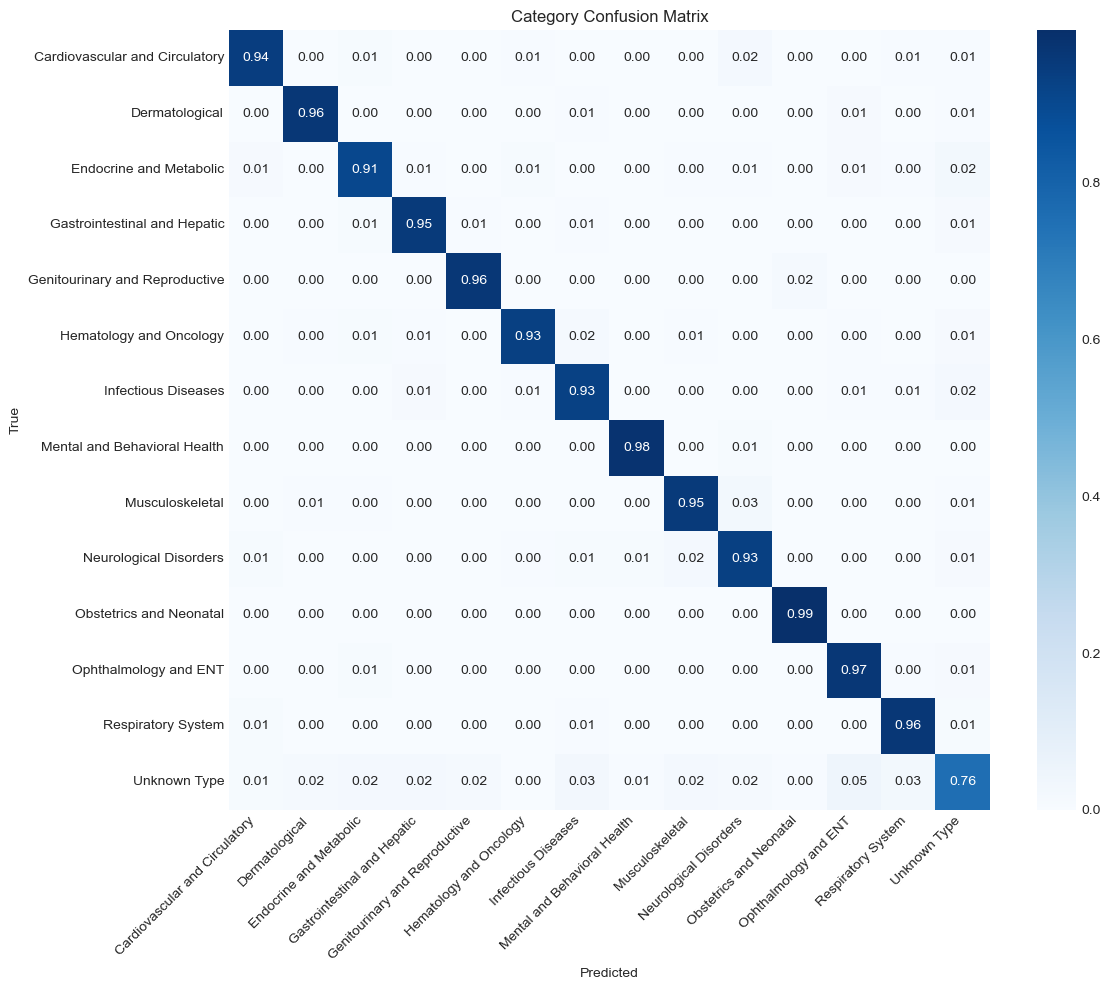

In [35]:
# Category confusion matrix
cm = confusion_matrix(y_cat_test_d, cat_pred_d)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Category Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'figures' / 'confusion_matrix.png', dpi=150)
plt.show()

In [36]:
# Final summary
print("\n" + "="*70)
print("PAPER ABSTRACT KEY NUMBERS")
print("="*70)
print(f"• Dataset: {len(df_symptoms):,} samples, {len(disease_encoder.classes_)} diseases")
print(f"• Semantic Encoder: {len(encoder.symptoms)} symptoms, MiniLM embeddings")
print(f"• Category: {results['Category (+Demo)']['Top-1']*100:.1f}% Top-1")
print(f"• Disease: {results['Disease (+Demo)']['Top-1']*100:.1f}% Top-1, {results['Disease (+Demo)']['Top-5']*100:.1f}% Top-5")
print(f"• Demographics: +{improvement_dis:.1f}% improvement")
print(f"• vs Baselines: +{(lgb_acc-lr_acc)*100:.1f}% over LR, +{(lgb_acc-rf_acc)*100:.1f}% over RF")


PAPER ABSTRACT KEY NUMBERS
• Dataset: 207,387 samples, 615 diseases
• Semantic Encoder: 458 symptoms, MiniLM embeddings
• Category: 92.9% Top-1
• Disease: 81.1% Top-1, 92.0% Top-5
• Demographics: +2.9% improvement
• vs Baselines: +1.9% over LR, +16.8% over RF


---
# Part 8: Final Model Comparison & Visualization

Saved figure to figures/final_comparison.png


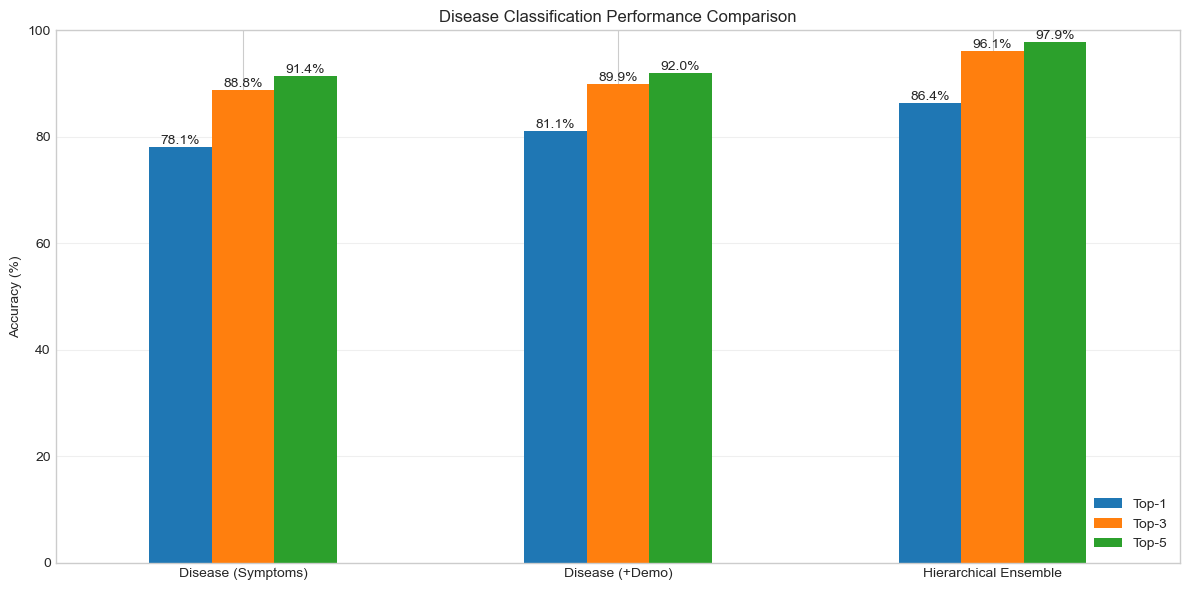

Comparing Key Models:
                       Top-1  Top-3  Top-5
Disease (Symptoms)     78.14  88.84  91.36
Disease (+Demo)        81.06  89.91  92.04
Hierarchical Ensemble  86.40  96.08  97.91


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data for plotting
models = ['Disease (Symptoms)', 'Disease (+Demo)', 'Hierarchical Ensemble']
metrics = ['Top-1', 'Top-3', 'Top-5']

data = []
for m in models:
    if m in results:
        row = [results[m][met] * 100 for met in metrics]
        data.append(row)
    else:
        print(f"Warning: {m} not in results")
        data.append([0, 0, 0])

plot_df = pd.DataFrame(data, columns=metrics, index=models)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
plot_df.plot(kind='bar', ax=ax, rot=0)
plt.title('Disease Classification Performance Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

figures_dir = project_root / 'notebooks' / 'figures'
figures_dir.mkdir(exist_ok=True)
try:
    plt.tight_layout()
    plt.savefig(figures_dir / 'final_comparison.png')
    print("Saved figure to figures/final_comparison.png")
except Exception as e:
    print(f"Could not save figure: {e}")

plt.show()

print("Comparing Key Models:")
print(plot_df.round(2))